In [1]:
import torch
import torchvision
import sklearn
import matplotlib
import numpy as np

print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("NumPy version:", np.__version__)


PyTorch version: 2.4.0+cu118
TorchVision version: 0.19.0+cu118
scikit-learn version: 1.5.1
Matplotlib version: 3.9.2
NumPy version: 1.26.3


Verificamos si tenemos CUDA disponible, este cuadernillo se corrió de manera local, por tanto, nos detecta nuestra tarjeta gráfica NVIDIA GeForce GTX 1060 de 6GB de memoria

In [2]:
import torch

# Verificar si CUDA está disponible
cuda_available = torch.cuda.is_available()

# Imprimir si CUDA está disponible y la versión de CUDA
print(f"CUDA disponible: {cuda_available}")

if cuda_available:
    print(f"Versión de CUDA: {torch.version.cuda}")
    print(f"Dispositivo CUDA: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA no está disponible.")


CUDA disponible: True
Versión de CUDA: 11.8
Dispositivo CUDA: NVIDIA GeForce GTX 1060 6GB


# Importar  Dataset

# Dataset de calidad del agua de Kaggle

Importamos el dataset

In [105]:
dataset = pd.read_csv('Water Quality Prediction.csv')
dataset.head()

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,...,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
0,0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,...,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,January,29.0,4.0,0
1,1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,...,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,November,26.0,16.0,0
2,2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,...,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,January,31.0,8.0,0
3,3,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,Near Colorless,0.166319,0.208454,...,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,April,1.0,21.0,0
4,4,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,Light Yellow,0.004867,0.222912,...,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,June,29.0,7.0,0


Asignamos la columna index como indice

In [106]:
# Asignar la columna 'Index' como índice
dataset.set_index('Index', inplace=True)

# Eliminar la columna 'Target'
dataset.drop('Target', axis=1, inplace=True)

# Verificar los primeros registros para confirmar los cambios
dataset.head()

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,...,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day
Index,,,,,,,,,,,,,,,,,,,,,
0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,0.144599,...,471.683357,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,January,29.0,4.0
1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,...,432.844908,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,November,26.0,16.0
2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,...,990.201209,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,January,31.0,8.0
3,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,Near Colorless,0.166319,0.208454,0.239451,...,237.028468,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,April,1.0,21.0
4,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,Light Yellow,0.004867,0.222912,0.616574,...,385.025855,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,June,29.0,7.0


El dataset consta de varias fuentes de agua, rios, lagos, cañerias, etc.
En este caso para que se parezca al area donde se aplicará entonces se filtro solamente los datos de agua de rio.

In [107]:
# Obtener las categorías únicas de la columna 'Source'
categorias_source = dataset['Source'].unique()

# Imprimir las categorías
print(categorias_source)


[nan 'Lake' 'River' 'Ground' 'Spring' 'Stream' 'Aquifer' 'Reservoir'
 'Well']


In [108]:
# Filtrar el dataset para quedarse solo con las filas donde 'Source' es 'River'
dataset_river = dataset.loc[dataset['Source'] == 'River']

# Verificar el nuevo dataset
dataset_river.head()


,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,...,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day
Index,,,,,,,,,,,,,,,,,,,,,
2,5.443762,2.010586e-02,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,...,990.201209,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,January,31.0,8.0
7,7.258203,6.110000e-09,9.261676,182.242341,4.400000e-224,0.416478,Colorless,0.047803,1.016196,0.298093,...,160.062557,2.325094,6.020000e-16,214.553104,River,15.891905,61.139140,April,11.0,4.0
9,7.100650,3.019038e-03,3.620641,157.043934,6.460000e-148,0.112994,Colorless,0.050613,0.842107,0.391602,...,583.295321,2.284971,8.840000e-07,113.909077,River,11.899376,14.010268,April,7.0,12.0
20,9.686076,2.048400e-04,9.588365,240.350234,6.900000e-23,5.448293,Faint Yellow,0.040746,0.926771,1.194378,...,280.930764,3.338544,6.576640e-04,270.921435,River,7.824436,32.121731,August,13.0,7.0
44,5.400853,7.340000e-14,5.739483,177.395747,1.950000e-100,1.402138,Light Yellow,0.345791,0.116614,0.294291,...,656.433055,2.770273,3.074910e-01,478.567391,River,29.371510,61.400910,September,10.0,15.0


In [109]:
# Verificar cuántas filas tiene el dataset
num_filas = dataset_river.shape[0]
print(f"El dataset tiene {num_filas} tuplas.")


El dataset tiene 128978 tuplas.


Eliminamos columna de Time of Day

In [110]:
# Eliminar las columnas y 'Time of Day'
dataset_river = dataset_river.drop([ 'Time of Day'], axis=1)

# Eliminar todas las filas que contienen valores NaN
dataset_river = dataset_river.dropna()

# Verificar que las columnas se eliminaron y las filas con NaN se eliminaron
print(dataset_river.head())
print(f"El dataset ahora tiene {dataset_river.shape[0]} tuplas y {dataset_river.shape[1]} columnas.")


             pH          Iron   Nitrate    Chloride           Lead      Zinc  \
Index                                                                          
2      5.443762  2.010586e-02  3.816994  230.995630   5.290000e-76  0.528280   
7      7.258203  6.110000e-09  9.261676  182.242341  4.400000e-224  0.416478   
9      7.100650  3.019038e-03  3.620641  157.043934  6.460000e-148  0.112994   
20     9.686076  2.048400e-04  9.588365  240.350234   6.900000e-23  5.448293   
51     7.745499  1.118435e-02  7.693283   92.052444   8.540000e-11  0.015602   

              Color  Turbidity  Fluoride    Copper  ...     Sulfate  \
Index                                               ...               
2      Light Yellow   0.319956  0.423423  0.431588  ...  275.702107   
7         Colorless   0.047803  1.016196  0.298093  ...  114.551427   
9         Colorless   0.050613  0.842107  0.391602  ...  167.417837   
20     Faint Yellow   0.040746  0.926771  1.194378  ...  128.283411   
51        Col

In [111]:
# Eliminar las columnas 'Color', 'Total Dissolved Solids', y 'Source'
dataset_river = dataset_river.drop(['Color', 'Total Dissolved Solids', 'Source'], axis=1)

# Verificar que las columnas se eliminaron
print(dataset_river.head())
print(f"El dataset ahora tiene {dataset_river.shape[0]} tuplas y {dataset_river.shape[1]} columnas.")


             pH          Iron   Nitrate    Chloride           Lead      Zinc  \
Index                                                                          
2      5.443762  2.010586e-02  3.816994  230.995630   5.290000e-76  0.528280   
7      7.258203  6.110000e-09  9.261676  182.242341  4.400000e-224  0.416478   
9      7.100650  3.019038e-03  3.620641  157.043934  6.460000e-148  0.112994   
20     9.686076  2.048400e-04  9.588365  240.350234   6.900000e-23  5.448293   
51     7.745499  1.118435e-02  7.693283   92.052444   8.540000e-11  0.015602   

       Turbidity  Fluoride    Copper      Odor     Sulfate  Conductivity  \
Index                                                                      
2       0.319956  0.423423  0.431588  3.414619  275.702107    990.201209   
7       0.047803  1.016196  0.298093  3.144199  114.551427    160.062557   
9       0.050613  0.842107  0.391602  2.713379  167.417837    583.295321   
20      0.040746  0.926771  1.194378  2.937562  128.283411 

In [112]:
# Contar cuántas filas hay por cada mes
conteo_meses = dataset_river['Month'].value_counts()

# Mostrar los resultados
print(conteo_meses)


Month
January      7689
October      7650
April        7603
December     7574
March        7554
May          7552
July         7544
June         7483
August       7466
November     7303
September    7217
February     6730
Name: count, dtype: int64


Filtramos los datos

In [113]:
df_filtered = dataset_river.query('Day == 1.0')

print(df_filtered)

               pH          Iron    Nitrate    Chloride           Lead  \
Index                                                                   
250      8.194909  1.164868e-01   4.695976   63.010549   1.190000e-50   
318      7.844306  7.872412e-02   4.232520  133.823863  1.580000e-111   
1192     7.317160  7.470000e-05   2.295930   98.324835   4.290000e-67   
1224     7.369789  3.690175e-03   3.230960  410.591986  7.110000e-238   
1236     6.966324  4.360000e-06   3.556849  135.650575  1.810000e-123   
...           ...           ...        ...         ...            ...   
1047277  7.245521  6.150000e-15   8.136507  134.179042  2.440000e-169   
1047777  7.228828  1.337857e-03   6.561615  212.967099   3.290000e-27   
1047865  7.428321  1.280909e-01   5.512299  246.712604   5.200000e-31   
1048142  7.869959  5.690000e-05  10.014334  104.534225   7.700000e-66   
1048398  6.545219  2.290300e-03   4.412670  197.671658   5.700000e-85   

             Zinc  Turbidity  Fluoride    Copper  

In [114]:
print(df_filtered.head())

             pH      Iron   Nitrate    Chloride           Lead      Zinc  \
Index                                                                      
250    8.194909  0.116487  4.695976   63.010549   1.190000e-50  0.979271   
318    7.844306  0.078724  4.232520  133.823863  1.580000e-111  0.044217   
1192   7.317160  0.000075  2.295930   98.324835   4.290000e-67  0.300929   
1224   7.369789  0.003690  3.230960  410.591986  7.110000e-238  0.028006   
1236   6.966324  0.000004  3.556849  135.650575  1.810000e-123  1.812094   

       Turbidity  Fluoride    Copper      Odor     Sulfate  Conductivity  \
Index                                                                      
250     0.029121  0.148764  0.346474  3.101467  163.969249    275.882073   
318     0.522605  0.155989  0.075699  1.688479  120.838042    414.324895   
1192    0.024352  0.305436  0.055203  1.556193   85.117573    275.952098   
1224    0.288160  0.788294  2.519866  3.535644  107.889991    394.124487   
1236    0.9

Ordenamos segun los meses

In [115]:
month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# Aplicar el diccionario para convertir los nombres de los meses a números
df_filtered['Month'] = df_filtered['Month'].map(month_mapping)

print(df_filtered)

               pH          Iron    Nitrate    Chloride           Lead  \
Index                                                                   
250      8.194909  1.164868e-01   4.695976   63.010549   1.190000e-50   
318      7.844306  7.872412e-02   4.232520  133.823863  1.580000e-111   
1192     7.317160  7.470000e-05   2.295930   98.324835   4.290000e-67   
1224     7.369789  3.690175e-03   3.230960  410.591986  7.110000e-238   
1236     6.966324  4.360000e-06   3.556849  135.650575  1.810000e-123   
...           ...           ...        ...         ...            ...   
1047277  7.245521  6.150000e-15   8.136507  134.179042  2.440000e-169   
1047777  7.228828  1.337857e-03   6.561615  212.967099   3.290000e-27   
1047865  7.428321  1.280909e-01   5.512299  246.712604   5.200000e-31   
1048142  7.869959  5.690000e-05  10.014334  104.534225   7.700000e-66   
1048398  6.545219  2.290300e-03   4.412670  197.671658   5.700000e-85   

             Zinc  Turbidity  Fluoride    Copper  

/tmp/ipykernel_28288/948409669.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered['Month'].map(month_mapping)


In [116]:
print(df_filtered.head())

             pH      Iron   Nitrate    Chloride           Lead      Zinc  \
Index                                                                      
250    8.194909  0.116487  4.695976   63.010549   1.190000e-50  0.979271   
318    7.844306  0.078724  4.232520  133.823863  1.580000e-111  0.044217   
1192   7.317160  0.000075  2.295930   98.324835   4.290000e-67  0.300929   
1224   7.369789  0.003690  3.230960  410.591986  7.110000e-238  0.028006   
1236   6.966324  0.000004  3.556849  135.650575  1.810000e-123  1.812094   

       Turbidity  Fluoride    Copper      Odor     Sulfate  Conductivity  \
Index                                                                      
250     0.029121  0.148764  0.346474  3.101467  163.969249    275.882073   
318     0.522605  0.155989  0.075699  1.688479  120.838042    414.324895   
1192    0.024352  0.305436  0.055203  1.556193   85.117573    275.952098   
1224    0.288160  0.788294  2.519866  3.535644  107.889991    394.124487   
1236    0.9

In [117]:
# Eliminar la columna 'Day'
df_filtered = df_filtered.drop(columns=['Day'])

# Contar el número de tuplas (filas) en el DataFrame
num_tuplas = df_filtered.shape[0]

print(df_filtered)
print(f"Número de tuplas: {num_tuplas}")


               pH          Iron    Nitrate    Chloride           Lead  \
Index                                                                   
250      8.194909  1.164868e-01   4.695976   63.010549   1.190000e-50   
318      7.844306  7.872412e-02   4.232520  133.823863  1.580000e-111   
1192     7.317160  7.470000e-05   2.295930   98.324835   4.290000e-67   
1224     7.369789  3.690175e-03   3.230960  410.591986  7.110000e-238   
1236     6.966324  4.360000e-06   3.556849  135.650575  1.810000e-123   
...           ...           ...        ...         ...            ...   
1047277  7.245521  6.150000e-15   8.136507  134.179042  2.440000e-169   
1047777  7.228828  1.337857e-03   6.561615  212.967099   3.290000e-27   
1047865  7.428321  1.280909e-01   5.512299  246.712604   5.200000e-31   
1048142  7.869959  5.690000e-05  10.014334  104.534225   7.700000e-66   
1048398  6.545219  2.290300e-03   4.412670  197.671658   5.700000e-85   

             Zinc  Turbidity  Fluoride    Copper  

Ordenamos por meses mapeados a numeros del 1 al 12 en series

In [118]:
import pandas as pd


# Crear una lista para almacenar los datos ordenados
sorted_data = []

# Obtener los meses únicos y ordenarlos
months = sorted(df_filtered['Month'].unique())

# Repetir hasta que todos los datos hayan sido procesados
while not df_filtered.empty:
    for month in months:
        # Filtrar los datos para el mes actual
        month_data = df_filtered[df_filtered['Month'] == month]
        
        # Si hay datos para el mes, agregar el primero a la lista de resultados y eliminarlo del DataFrame
        if not month_data.empty:
            sorted_data.append(month_data.iloc[0])
            df_filtered = df_filtered.drop(month_data.index[0])

# Convertir la lista de resultados a un DataFrame
df_sorted = pd.DataFrame(sorted_data).reset_index(drop=True)

print(df_sorted)


            pH          Iron   Nitrate    Chloride           Lead      Zinc  \
0     8.194909  1.164868e-01  4.695976   63.010549   1.190000e-50  0.979271   
1     7.749006  1.350000e-08  2.224282  124.392751   1.650000e-79  1.425599   
2     6.942280  2.990000e-05  5.226973  166.793638   7.890000e-57  1.925964   
3     6.966324  4.360000e-06  3.556849  135.650575  1.810000e-123  1.812094   
4     7.369789  3.690175e-03  3.230960  410.591986  7.110000e-238  0.028006   
...        ...           ...       ...         ...            ...       ...   
2945  7.575876  8.260000e-08  7.041473  171.338472   0.000000e+00  0.027687   
2946  6.579088  1.944220e-04  5.718072  181.900230  3.680000e-120  0.069914   
2947  7.070593  2.180000e-14  7.706004  163.879439   7.810000e-60  0.626789   
2948  7.978396  9.180000e-05  3.957409  194.912763   2.087086e-03  2.941358   
2949  6.868406  1.174400e-04  7.343255  145.661304  6.640000e-203  0.304974   

      Turbidity  Fluoride    Copper      Odor     S

In [119]:
print(df_sorted.head(14))

          pH          Iron   Nitrate    Chloride           Lead      Zinc  \
0   8.194909  1.164868e-01  4.695976   63.010549   1.190000e-50  0.979271   
1   7.749006  1.350000e-08  2.224282  124.392751   1.650000e-79  1.425599   
2   6.942280  2.990000e-05  5.226973  166.793638   7.890000e-57  1.925964   
3   6.966324  4.360000e-06  3.556849  135.650575  1.810000e-123  1.812094   
4   7.369789  3.690175e-03  3.230960  410.591986  7.110000e-238  0.028006   
5   7.844306  7.872412e-02  4.232520  133.823863  1.580000e-111  0.044217   
6   7.125456  4.470000e-05  2.248191  132.562021   1.500000e-10  0.106776   
7   8.352718  6.650000e-05  8.115286  220.810340   1.900000e-46  0.532160   
8   7.317160  7.470000e-05  2.295930   98.324835   4.290000e-67  0.300929   
9   8.063649  2.654860e-04  4.232997   91.602805   2.410000e-77  4.796850   
10  6.888702  1.716200e-04  6.283869  203.829395   3.180000e-27  0.728147   
11  9.418386  6.587689e-02  3.639363  169.200212   0.000000e+00  0.876102   

Añadimos la columna de año ficticio para poder ordenar segun años

In [121]:
import pandas as pd

# Suponiendo que tu DataFrame es df
# Añadimos la columna de Año
df_sorted['Year'] = 2000 + (df_sorted.index // 12)

# Mostrar el DataFrame con la nueva columna de Año
print(df_sorted.head(20))  # Mostrar las primeras filas para verificar


          pH          Iron   Nitrate    Chloride           Lead      Zinc  \
0   8.194909  1.164868e-01  4.695976   63.010549   1.190000e-50  0.979271   
1   7.749006  1.350000e-08  2.224282  124.392751   1.650000e-79  1.425599   
2   6.942280  2.990000e-05  5.226973  166.793638   7.890000e-57  1.925964   
3   6.966324  4.360000e-06  3.556849  135.650575  1.810000e-123  1.812094   
4   7.369789  3.690175e-03  3.230960  410.591986  7.110000e-238  0.028006   
5   7.844306  7.872412e-02  4.232520  133.823863  1.580000e-111  0.044217   
6   7.125456  4.470000e-05  2.248191  132.562021   1.500000e-10  0.106776   
7   8.352718  6.650000e-05  8.115286  220.810340   1.900000e-46  0.532160   
8   7.317160  7.470000e-05  2.295930   98.324835   4.290000e-67  0.300929   
9   8.063649  2.654860e-04  4.232997   91.602805   2.410000e-77  4.796850   
10  6.888702  1.716200e-04  6.283869  203.829395   3.180000e-27  0.728147   
11  9.418386  6.587689e-02  3.639363  169.200212   0.000000e+00  0.876102   

In [123]:
print(df_sorted.head(13))  # Mostrar las primeras filas para verificar

          pH          Iron   Nitrate    Chloride           Lead      Zinc  \
0   8.194909  1.164868e-01  4.695976   63.010549   1.190000e-50  0.979271   
1   7.749006  1.350000e-08  2.224282  124.392751   1.650000e-79  1.425599   
2   6.942280  2.990000e-05  5.226973  166.793638   7.890000e-57  1.925964   
3   6.966324  4.360000e-06  3.556849  135.650575  1.810000e-123  1.812094   
4   7.369789  3.690175e-03  3.230960  410.591986  7.110000e-238  0.028006   
5   7.844306  7.872412e-02  4.232520  133.823863  1.580000e-111  0.044217   
6   7.125456  4.470000e-05  2.248191  132.562021   1.500000e-10  0.106776   
7   8.352718  6.650000e-05  8.115286  220.810340   1.900000e-46  0.532160   
8   7.317160  7.470000e-05  2.295930   98.324835   4.290000e-67  0.300929   
9   8.063649  2.654860e-04  4.232997   91.602805   2.410000e-77  4.796850   
10  6.888702  1.716200e-04  6.283869  203.829395   3.180000e-27  0.728147   
11  9.418386  6.587689e-02  3.639363  169.200212   0.000000e+00  0.876102   

Cantidad de años generados

In [124]:
# Contar el número de años distintos en la columna 'Year'
num_years = df_sorted['Year'].nunique()

print(f"Cantidad de años generados: {num_years}")


Cantidad de años generados: 246


In [125]:
# Imprimir la cantidad de tuplas (filas) en el DataFrame
num_rows = df_sorted.shape[0]

print(f"Cantidad de tuplas: {num_rows}")


Cantidad de tuplas: 2950


In [126]:
# Filtrar el DataFrame para que contenga solo los años entre 2000 y 2100
df_filtered_years = df_sorted[(df_sorted['Year'] >= 2000) & (df_sorted['Year'] <= 2100)]

# Mostrar las primeras filas del nuevo DataFrame para verificar
print(df_filtered_years.head())


         pH          Iron   Nitrate    Chloride           Lead      Zinc  \
0  8.194909  1.164868e-01  4.695976   63.010549   1.190000e-50  0.979271   
1  7.749006  1.350000e-08  2.224282  124.392751   1.650000e-79  1.425599   
2  6.942280  2.990000e-05  5.226973  166.793638   7.890000e-57  1.925964   
3  6.966324  4.360000e-06  3.556849  135.650575  1.810000e-123  1.812094   
4  7.369789  3.690175e-03  3.230960  410.591986  7.110000e-238  0.028006   

   Turbidity  Fluoride    Copper      Odor     Sulfate  Conductivity  \
0   0.029121  0.148764  0.346474  3.101467  163.969249    275.882073   
1   0.090278  1.440512  0.529665  1.841168   90.465978    181.883567   
2   0.405447  0.635160  0.002329  2.832792  206.204723    340.797977   
3   0.978910  0.788451  0.350030  1.071204   54.665392    699.731771   
4   0.288160  0.788294  2.519866  3.535644  107.889991    394.124487   

   Chlorine  Manganese  Water Temperature  Air Temperature  Month  Year  
0  3.086794   0.000003          23.8

In [127]:
num_rows = df_filtered_years.shape[0]

print(f"Cantidad de tuplas: {num_rows}")

Cantidad de tuplas: 1212


In [128]:
import pandas as pd

# Supongamos que df_filtered_years es el DataFrame original

# Crear una nueva columna de fecha combinando 'Month', 'Year', y 'Day' con el valor predeterminado de 1
df_filtered_years['Date'] = pd.to_datetime(df_filtered_years[['Year', 'Month']].assign(Day=1))

# Establecer la columna 'Date' como índice del DataFrame
df_filtered_years.set_index('Date', inplace=True)

# Eliminar las columnas 'Month' y 'Year'
df_filtered_years.drop(columns=['Month', 'Year'], inplace=True)

# Mostrar las primeras filas del DataFrame actualizado para verificar
print(df_filtered_years.head())


                  pH          Iron   Nitrate    Chloride           Lead  \
Date                                                                      
2000-01-01  8.194909  1.164868e-01  4.695976   63.010549   1.190000e-50   
2000-02-01  7.749006  1.350000e-08  2.224282  124.392751   1.650000e-79   
2000-03-01  6.942280  2.990000e-05  5.226973  166.793638   7.890000e-57   
2000-04-01  6.966324  4.360000e-06  3.556849  135.650575  1.810000e-123   
2000-05-01  7.369789  3.690175e-03  3.230960  410.591986  7.110000e-238   

                Zinc  Turbidity  Fluoride    Copper      Odor     Sulfate  \
Date                                                                        
2000-01-01  0.979271   0.029121  0.148764  0.346474  3.101467  163.969249   
2000-02-01  1.425599   0.090278  1.440512  0.529665  1.841168   90.465978   
2000-03-01  1.925964   0.405447  0.635160  0.002329  2.832792  206.204723   
2000-04-01  1.812094   0.978910  0.788451  0.350030  1.071204   54.665392   
2000-05-01  

/tmp/ipykernel_28288/958285645.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_years['Date'] = pd.to_datetime(df_filtered_years[['Year', 'Month']].assign(Day=1))
/tmp/ipykernel_28288/958285645.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_years.drop(columns=['Month', 'Year'], inplace=True)


Filtramos hasta el supuesto 2040 de años, lo improtante son las curvas para las predicciones asi que tomaremos hasta 2040

In [133]:
import pandas as pd

# Supongamos que df_filtered_years es el DataFrame con la columna 'Date' como índice

# Filtrar el DataFrame hasta el año 2040
df_until_2040 = df_filtered_years[df_filtered_years.index <= '2040-12-31']

# Mostrar las primeras filas del DataFrame filtrado para verificar
print(df_until_2040.head())


                  pH          Iron   Nitrate    Chloride           Lead  \
Date                                                                      
2000-01-01  8.194909  1.164868e-01  4.695976   63.010549   1.190000e-50   
2000-02-01  7.749006  1.350000e-08  2.224282  124.392751   1.650000e-79   
2000-03-01  6.942280  2.990000e-05  5.226973  166.793638   7.890000e-57   
2000-04-01  6.966324  4.360000e-06  3.556849  135.650575  1.810000e-123   
2000-05-01  7.369789  3.690175e-03  3.230960  410.591986  7.110000e-238   

                Zinc  Turbidity  Fluoride    Copper      Odor     Sulfate  \
Date                                                                        
2000-01-01  0.979271   0.029121  0.148764  0.346474  3.101467  163.969249   
2000-02-01  1.425599   0.090278  1.440512  0.529665  1.841168   90.465978   
2000-03-01  1.925964   0.405447  0.635160  0.002329  2.832792  206.204723   
2000-04-01  1.812094   0.978910  0.788451  0.350030  1.071204   54.665392   
2000-05-01  

Dataset completamente ordenado, ahora graficamos un dato vs el nuevo index que es la fecha (ph)

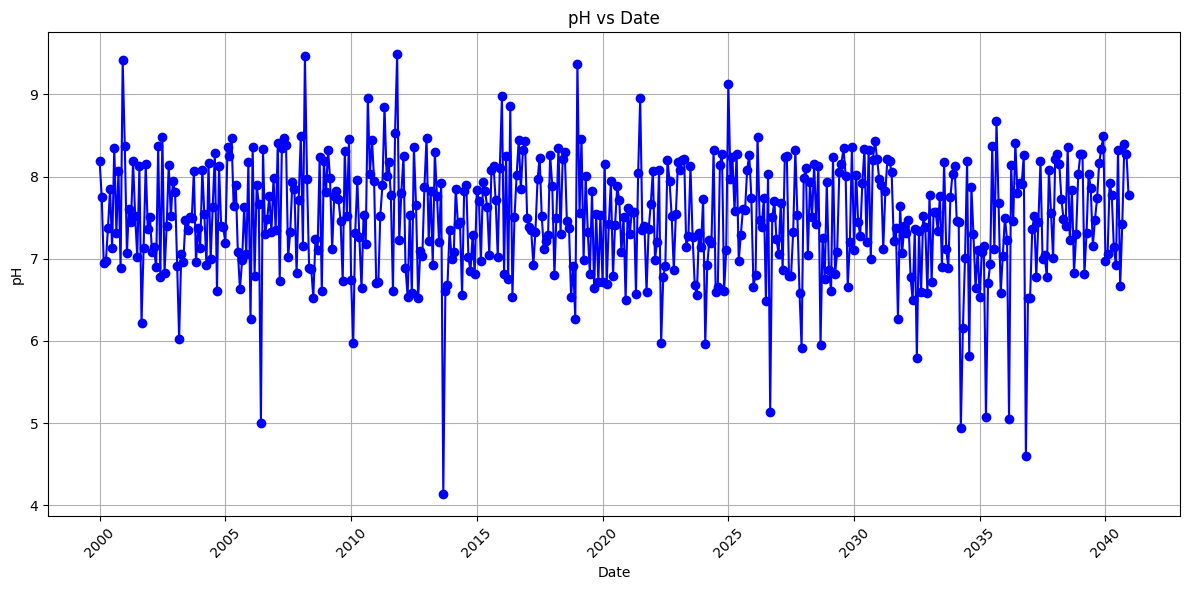

In [135]:
import matplotlib.pyplot as plt

# Supongamos que df_until_2040 es el DataFrame con 'pH' y 'Date' como índice

# Graficar pH frente a Date
plt.figure(figsize=(12, 6))
plt.plot(df_until_2040.index, df_until_2040['pH'], marker='o', linestyle='-', color='b')
plt.title('pH vs Date')
plt.xlabel('Date')
plt.ylabel('pH')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Ajusta el diseño para que se vean bien las etiquetas
plt.show()


In [138]:
import pandas as pd
import numpy as np

# Supongamos que df es tu DataFrame original

# Definir pesos para cada parámetro
weights = {
    'pH': 0.2,
    'Conductivity': 0.2,
    'Chlorine': 0.2,
    'Turbidity': 0.2,
    'Air Temperature': 0.2
}

# Normalización de cada parámetro (escala inversa para pH y Turbidity ya que valores altos son peores)
def normalize(df, column, reverse=False):
    min_val = df[column].min()
    max_val = df[column].max()
    norm = (df[column] - min_val) / (max_val - min_val)
    return 1 - norm if reverse else norm

# Normalizar parámetros
df_normalized = pd.DataFrame(index=df_until_2040.index)
for column in weights.keys():
    reverse = column in ['pH', 'Turbidity']  # Para parámetros donde valores altos son peores
    df_normalized[column] = normalize(df_until_2040, column, reverse=reverse)

# Calcular el índice de calidad del agua
df_normalized['Water Quality Index'] = df_normalized.apply(lambda x: np.dot(x, list(weights.values())), axis=1)

# Agregar la columna del índice de calidad al DataFrame original
df_until_2040['Water Quality Index'] = df_normalized['Water Quality Index']

# Imprimir las primeras filas para verificar
print(df_until_2040[['Water Quality Index']].head())


            Water Quality Index
Date                           
2000-01-01             0.374214
2000-02-01             0.423959
2000-03-01             0.394162
2000-04-01             0.634205
2000-05-01             0.420479


/tmp/ipykernel_28288/3421566857.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_until_2040['Water Quality Index'] = df_normalized['Water Quality Index']


Calculamos y aumentamos al dataframe el indice de calidad del agua

In [139]:
print(df_until_2040.head())

                  pH          Iron   Nitrate    Chloride           Lead  \
Date                                                                      
2000-01-01  8.194909  1.164868e-01  4.695976   63.010549   1.190000e-50   
2000-02-01  7.749006  1.350000e-08  2.224282  124.392751   1.650000e-79   
2000-03-01  6.942280  2.990000e-05  5.226973  166.793638   7.890000e-57   
2000-04-01  6.966324  4.360000e-06  3.556849  135.650575  1.810000e-123   
2000-05-01  7.369789  3.690175e-03  3.230960  410.591986  7.110000e-238   

                Zinc  Turbidity  Fluoride    Copper      Odor     Sulfate  \
Date                                                                        
2000-01-01  0.979271   0.029121  0.148764  0.346474  3.101467  163.969249   
2000-02-01  1.425599   0.090278  1.440512  0.529665  1.841168   90.465978   
2000-03-01  1.925964   0.405447  0.635160  0.002329  2.832792  206.204723   
2000-04-01  1.812094   0.978910  0.788451  0.350030  1.071204   54.665392   
2000-05-01  

## Separacion en entrenamiento y prueba

In [140]:
# Selección de características y objetivo
set_entrenamiento = df_until_2040[['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity', 'Chlorine', 'Manganese', 'Water Temperature', 'Air Temperature']][:'2035']
set_entrenamiento_target = df_until_2040[['Water Quality Index']][:'2035']

set_validacion = df_until_2040[['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity', 'Chlorine', 'Manganese', 'Water Temperature', 'Air Temperature']][
    '2035':]
set_validacion_target = df_until_2040[['Water Quality Index']]['2035':]


Separamos en entrenamiento y prueba, sera un LSTM de muchos a uno

In [141]:
# Normalización de características
sc_features = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc_features.fit_transform(set_entrenamiento)
set_validacion_escalado = sc_features.transform(set_validacion)

# Normalización del objetivo
sc_target = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_target_escalado = sc_target.fit_transform(set_entrenamiento_target)
set_validacion_target_escalado = sc_target.transform(set_validacion_target)


Normalizamos las caracteristicas

In [142]:
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step, m):
    X_train.append(set_entrenamiento_escalado[i-time_step:i, :])  # Todas las características
    Y_train.append(set_entrenamiento_target_escalado[i])  # La salida es Water Quality Index
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_validacion = []
for i in range(time_step, len(set_validacion_escalado)):
    X_validacion.append(set_validacion_escalado[i-time_step:i, :])  # Todas las características
X_validacion = np.array(X_validacion)


Creamos las series temporales con pasos de 60 unidades

In [143]:
X_train = torch.tensor(X_train, dtype=torch.float32)  # [batch_size, sequence_length, input_size]
Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)  # [batch_size, output_size]

X_validacion = torch.tensor(X_validacion, dtype=torch.float32)


Transformamos a tensores

In [146]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, 
                            batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Parámetros del modelo
input_size = 16  # Número de características
hidden_size = 50
output_size = 1  # Salida: Water Quality Index
num_layers = 2
dropout_prob = 0.2
batch_size = 32
epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_prob).to(device)


Definimos el entrenamiento

Epoch [5/200], Loss: 0.2346
Epoch [10/200], Loss: 0.1330
Epoch [15/200], Loss: 0.0418
Epoch [20/200], Loss: 0.0602
Epoch [25/200], Loss: 0.0394
Epoch [30/200], Loss: 0.0382
Epoch [35/200], Loss: 0.0370
Epoch [40/200], Loss: 0.0375
Epoch [45/200], Loss: 0.0379
Epoch [50/200], Loss: 0.0377
Epoch [55/200], Loss: 0.0374
Epoch [60/200], Loss: 0.0378
Epoch [65/200], Loss: 0.0379
Epoch [70/200], Loss: 0.0380
Epoch [75/200], Loss: 0.0383
Epoch [80/200], Loss: 0.0380
Epoch [85/200], Loss: 0.0383
Epoch [90/200], Loss: 0.0380
Epoch [95/200], Loss: 0.0380
Epoch [100/200], Loss: 0.0384
Epoch [105/200], Loss: 0.0388
Epoch [110/200], Loss: 0.0382
Epoch [115/200], Loss: 0.0372
Epoch [120/200], Loss: 0.0379
Epoch [125/200], Loss: 0.0378
Epoch [130/200], Loss: 0.0381
Epoch [135/200], Loss: 0.0373
Epoch [140/200], Loss: 0.0381
Epoch [145/200], Loss: 0.0379
Epoch [150/200], Loss: 0.0381
Epoch [155/200], Loss: 0.0379
Epoch [160/200], Loss: 0.0382
Epoch [165/200], Loss: 0.0381
Epoch [170/200], Loss: 0.0383


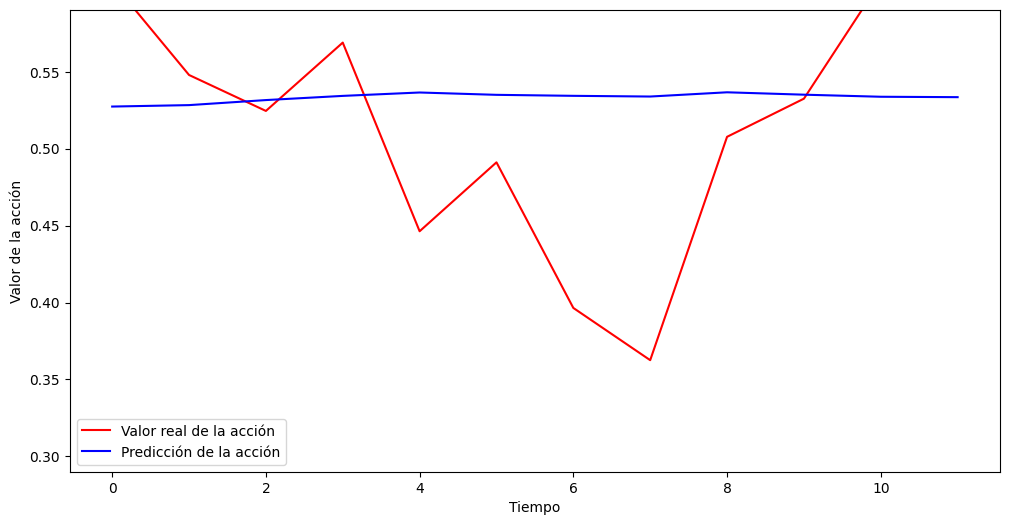

In [147]:
# Definir el optimizador y la función de pérdida
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Entrenamiento del modelo
for epoch in range(epochs):
    model.train()
    outputs = model(X_train.to(device))
    loss = criterion(outputs, Y_train.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    scheduler.step(loss)
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Validación
model.eval()
with torch.no_grad():
    prediccion = model(X_validacion.to(device))
    prediccion = prediccion.cpu().numpy()
    prediccion = sc_target.inverse_transform(prediccion)  # Desnormalizar la predicción

# Graficar resultados
real_data = set_validacion_target.values[time_step:]
graficar_predicciones(real_data, prediccion)


Obtenemos la prediccion vs el valor real del indice de calidad del agua

In [148]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calcular el MSE y RMSE
mse = mean_squared_error(real_data, prediccion)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_data, prediccion)

# Imprimir las métricas de error
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')


Mean Squared Error (MSE): 0.0066
Root Mean Squared Error (RMSE): 0.0811
Mean Absolute Error (MAE): 0.0640


Vemos que el error es bajo a pesra de no tener una muy buena grafica (prediccion) por loo que debemos tomar otro enfoque para mejorar la respuesta